In [341]:
from langgraph.graph import StateGraph, START, END
from pygments.lexer import words
from typing_extensions import TypedDict
from langgraph.types import CachePolicy
from langgraph.cache.memory import InMemoryCache
from datetime import datetime
from typing import Annotated
from langgraph.types import Send, Command

In [342]:
import operator


def update_function(old, new):
    return old + new


class InputState(TypedDict):
    hello: Annotated[list[str], update_function]


class State(TypedDict):
    words: list[str]
    output: Annotated[list[dict[str, int]], operator.add]
    transfer_reason: str
    support : str


graph_builder = StateGraph(State)


In [343]:
def node_one(state: State) -> State:
    return state


def node_two(word: str) -> State:
    return {
        "output": [
            {
                "word": word,
                "output": len(word)
            }
        ],
        "node_two_name": word
    }

def tech_support(state: State):
    print("Tech Support")
    return {
        "support": "Tech support",
    }

def account_support(state: State):
    print("Account Support")
    return {
        "support": "account_support",
    }
from typing import Literal

def triage_node(state: State) -> Command[Literal["tech_support", "account_support"]]:
    length_hint = len(state["output"])
    print(length_hint)
    return Command(
        goto="tech_support" if length_hint <= 3 else "account_support",
        update={
            "transfer_reason": "is need support",
        }
    )


In [344]:

graph_builder.add_node("node_one", node_one)
graph_builder.add_node("node_two", node_two)
graph_builder.add_node("triage_node", triage_node)
graph_builder.add_node("tech_support", tech_support)
graph_builder.add_node("account_support", account_support)


graph_builder.add_edge(START, "node_one")
def dispatcher(state: State):
    return [Send("node_two", word) for word in state["words"]]
graph_builder.add_conditional_edges("node_one", dispatcher, ["node_two"])
graph_builder.add_edge("node_two", "triage_node")
graph_builder.add_edge("tech_support", END)
graph_builder.add_edge("account_support", END)



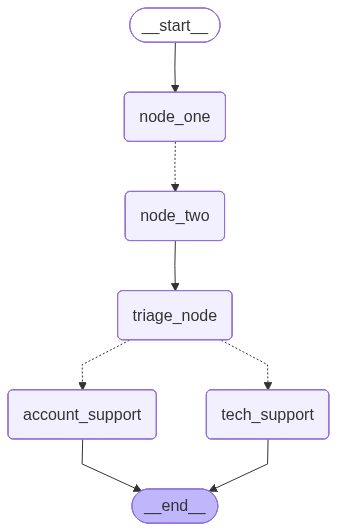

6
Account Support
result: {'words': ['hello', 'world', 'how', 'are', 'you', 'doing'], 'output': [{'word': 'hello', 'output': 5}, {'word': 'world', 'output': 5}, {'word': 'how', 'output': 3}, {'word': 'are', 'output': 3}, {'word': 'you', 'output': 3}, {'word': 'doing', 'output': 5}], 'transfer_reason': 'is need support', 'support': 'account_support'}


In [345]:
graph = graph_builder.compile(cache=InMemoryCache())
display(graph)
# print(graph.get_graph().draw_ascii())


import time

result = graph.invoke({
    "words": ["hello", "world", "how", "are", "you", "doing"],
})
print("result:", result)